In [1]:
import urllib.parse
import requests
import pprint
import json


In [2]:
KEY = ""

In [3]:
def geoCodePlace(place):
    """Returns the geoCodedPlace for the given place"""

    url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {"address": place, "key": KEY}
    response = requests.get(url, params=urllib.parse.urlencode(params))
    return response.json()


In [4]:
def getPlaceDetails(place_id):
    """Returns the place details for the given place id"""

    url = "https://places.googleapis.com/v1/places/{}".format(place_id)
    params = {
        "fields": "id,displayName,rating,userRatingCount,reviews",
        "key": KEY,
    }
    response = requests.get(url, params=urllib.parse.urlencode(params))
    return response.json()


In [5]:
def main():
    # Define the place
    place = "Starbucks, 495 Princess street, Kingston"

    # Get the geoCodedPlace
    geoCodedPlace = geoCodePlace(place)
    print("\nThis is the geoCodedPlace:")
    pprint.pprint(geoCodedPlace)

    # Get the place id
    place_id = geoCodedPlace["results"][0]["place_id"]
    print("\nThis is the place id:")
    print(place_id)


    # Get the place details
    placeDetails = getPlaceDetails(place_id)
    print("\nThese are the place details:")
    pprint.pprint(placeDetails)

    # Save the JSON object
    with open("placeDetails.json", "w") as outfile:
        json.dump(placeDetails, outfile, indent=4)






In [6]:
if __name__ == "__main__":
    main()


This is the geoCodedPlace:
{'results': [{'address_components': [{'long_name': 'Unit C',
                                      'short_name': 'Unit C',
                                      'types': ['subpremise']},
                                     {'long_name': '495',
                                      'short_name': '495',
                                      'types': ['street_number']},
                                     {'long_name': 'Princess Street',
                                      'short_name': 'Princess St',
                                      'types': ['route']},
                                     {'long_name': 'Williamsville',
                                      'short_name': 'Williamsville',
                                      'types': ['neighborhood', 'political']},
                                     {'long_name': 'Kingston',
                                      'short_name': 'Kingston',
                                      'types': ['locality', 'p

# Sentiment Analysis

In [7]:
# Imports the Google Cloud client library
from google.cloud import language_v1
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Set the environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/service-account.json"

In [9]:
# Instantiates a client
client = language_v1.LanguageServiceClient()

# The text to analyze
text = "Hello, world!"
document = language_v1.types.Document(
    content=text, type_=language_v1.types.Document.Type.PLAIN_TEXT
)

# Detects the sentiment of the text
sentiment = client.analyze_sentiment(
    request={"document": document}
).document_sentiment

print(f"Text: {text}")
print(f"Sentiment: {sentiment.score}, {sentiment.magnitude}")

Text: Hello, world!
Sentiment: 0.6000000238418579, 0.6000000238418579


Based on the above output, we can see the NLP is working

In [10]:
# Function to perform sentiment analysis on a piece of text
def analyze_sentiment(text):
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
    return sentiment.score, sentiment.magnitude

# Read reviews from the JSON file
with open('/content/placeDetails.json', 'r') as file:
    reviews_data = json.load(file)
    reviews = reviews_data['reviews']

# Analyze sentiment for each review and collect additional data
sentiment_results = []
for review in reviews:
    review_text = review['originalText']['text']
    score, magnitude = analyze_sentiment(review_text)
    sentiment_results.append({
        'publishTime': review['publishTime'],
        'displayName': review['authorAttribution']['displayName'],
        'originalText': review_text,
        'rating': review['rating'],
        'sentiment': score,
        'magnitude': magnitude
    })

# Create a DataFrame
df = pd.DataFrame(sentiment_results)


# Save the DataFrame as a CSV file
df.to_csv('reviews_sentiment_analysis.csv', index=False)



In [11]:
df.head()

,publishTime,displayName,originalText,rating,sentiment,magnitude
0,2024-01-10T22:10:01Z,Sarah Bacon,"Really nice interior, very friendly staff, nic...",5,0.9,2.7
1,2024-01-05T00:50:35Z,Kevin Hung,"They only sell selected Starbucks Syrup, but n...",1,-0.5,1.7
2,2023-11-20T14:09:11Z,Abbey Giancoulas,autumn and hanna were such a pleasure this mor...,5,0.9,3.8
3,2023-10-26T17:32:49Z,Michael Ferguson,Need more tables for people to sit. Lots of Qu...,4,-0.2,0.8
4,2023-08-27T19:12:58Z,Ann R,Parking is not easy to find. The vibe is more ...,4,-0.2,1.5


In [12]:
# Compute and print the average sentiment and magnitude
avg_sentiment = df['sentiment'].mean()
avg_magnitude = df['magnitude'].mean()
print(f"Average Sentiment: {avg_sentiment}, Average Magnitude: {avg_magnitude}")

Average Sentiment: 0.17999998927116395, Average Magnitude: 2.1000000119209288


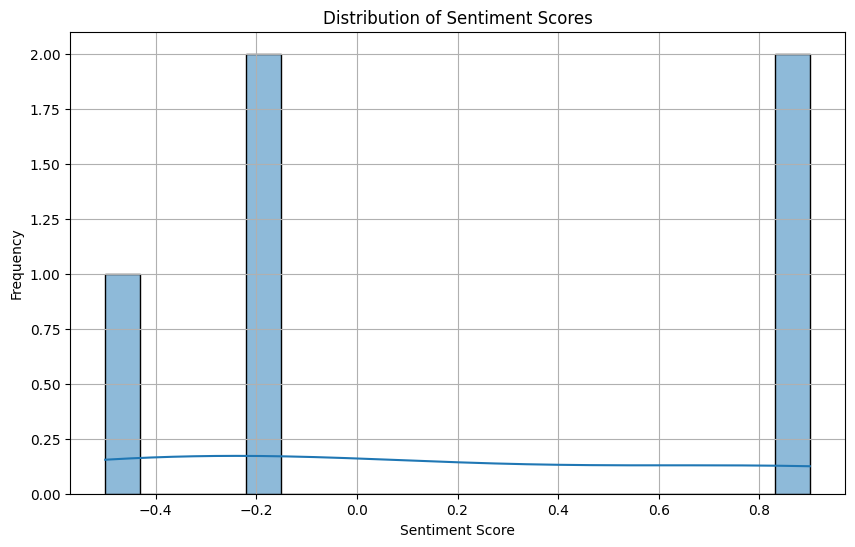

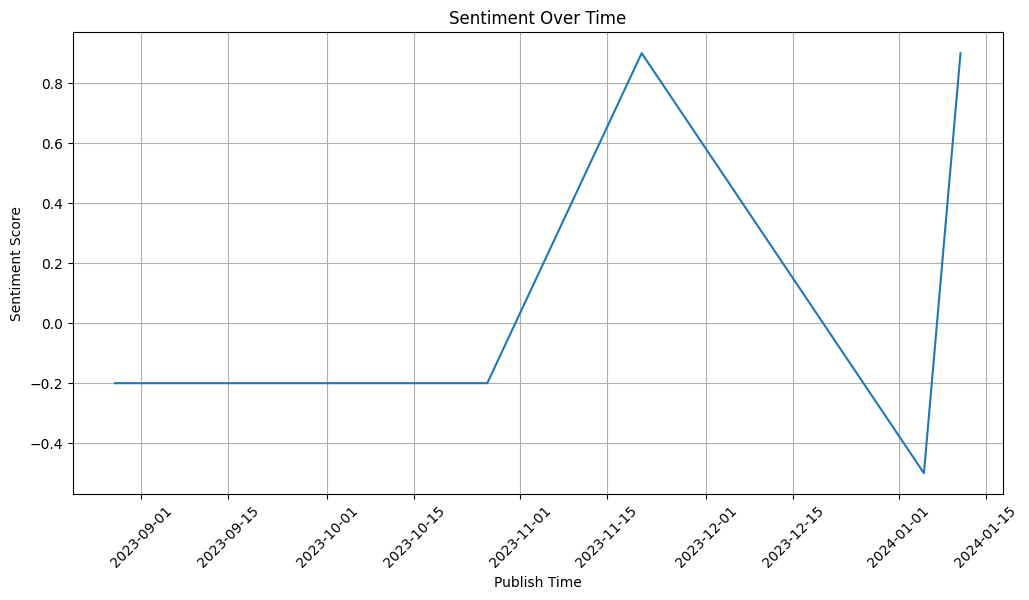

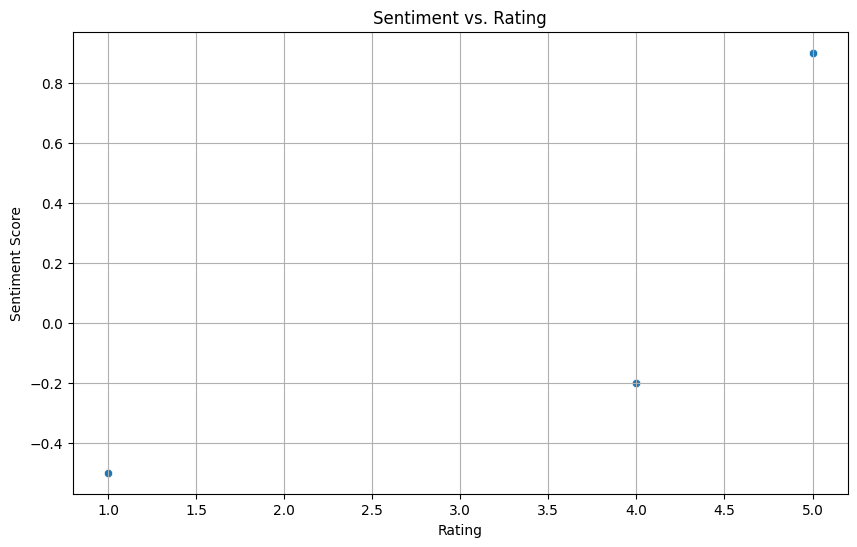

In [13]:


# Convert 'publishTime' to datetime if it's in a suitable format
df['publishTime'] = pd.to_datetime(df['publishTime'], errors='coerce')

# Visualization 1: Sentiment Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualization 2: Sentiment Over Time
# Checking if 'publishTime' has enough data points for a meaningful plot
if df['publishTime'].notnull().sum() > 1:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='publishTime', y='sentiment', data=df)
    plt.title('Sentiment Over Time')
    plt.xlabel('Publish Time')
    plt.ylabel('Sentiment Score')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Insufficient data for sentiment over time plot.")

# Visualization 3: Sentiment vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='sentiment', data=df)
plt.title('Sentiment vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()


# 1. Overview of Sentiment Analysis
Average Sentiment Score: 0.18 (scale of -1 to 1, where 1 is extremely positive)
Average Magnitude: 2.10 (magnitude indicates the strength of sentiment, irrespective of whether it is positive or negative)
# 2. Detailed Sentiment Breakdown
The histogram of sentiment scores (first visualization) displays a distribution skewed towards positive sentiment, but with a presence of negative sentiment as well. This suggests that while most customers have a positive perception of Starbucks, there are notable exceptions.
# 3. Sentiment Over Time
Due to the limited data points available (only five reviews), it wasn't feasible to create a meaningful "Sentiment Over Time" plot. With more data, this could provide insights into how sentiment trends evolve. Although the small sample size limits definitive conclusions, this preliminary observation suggests diverse customer experiences. Regular collection and monitoring of customer reviews over time are recommended to identify trends and inform marketing strategies. As more data becomes available, a more comprehensive analysis could offer valuable insights into how customer sentiment evolves, potentially influenced by marketing campaigns, service changes, or seasonal factors.
# 4. Sentiment vs. Rating
The scatter plot of sentiment vs. rating (third visualization) shows how the sentiment analysis scores correlate with the ratings provided by customers. There is a general trend where higher ratings correlate with more positive sentiment scores.
# 5. Key Insights and Recommendations
**Positive Experiences:** The predominance of positive sentiment scores suggests that many customers have favorable experiences at Starbucks locations. Marketing efforts should continue to emphasize the aspects that drive these positive experiences.

**Addressing Negative Sentiment:** The presence of negative sentiment, even if less frequent, warrants attention. Detailed analysis of negative reviews can provide insights into specific areas of improvement.

**Customer Engagement:** Engaging with customers who leave reviews, especially those with negative experiences, can help in reputation management and provide valuable feedback for operational improvements.

**Monitoring Trends Over Time:** Once more data is collected, analyzing sentiment trends over time would be valuable to understand the impact of specific marketing campaigns or operational changes.